In [2]:
InteractionsFileCaptureC='/mnt/lab_data/kundaje/mtaranov/ChicagoCalls/D0_D2D8_merge_BaitToE_intra.bed.gz'
pe_hindIII_file='/mnt/lab_data/kundaje/mtaranov/ChicagoCalls/PE_Digest_Human_HindIII_ID.bed'
PROJDIR='/users/mtaranov/NN_thres5max_datasets/'
DATAJDIR='/users/mtaranov/NN_thres5max_datasets/dist_matched_chr_Enhc/'
#DATAJDIR2='/users/mtaranov/NN_thres5max_datasets/no_dist_matched_chr/'

In [18]:
features_path='/mnt/lab_data/kundaje/mtaranov/peaks_at_pe/output_thres5_max/'
atac=features_path+'atac'
#TFs
ctcf=features_path+'CTCF'
pol3=features_path+'PolII'
TP63=features_path+'TP63'
LSD1=features_path+'LSD1'
#histone
H3K27ac=features_path+'H3K27ac'
H3K27me3=features_path+'H3K27me3'
H3K4me1=features_path+'H3K4me1'
H3K4me3=features_path+'H3K4me3'
H3K9ac=features_path+'H3K9ac'

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats.mstats import mquantiles
import scipy.stats as ss
import math
import scipy.linalg
import itertools
import copy
import random
import gzip
from sets import Set
#reload(rcca)
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
import networkx as nx

from utils_data_process import printMatrix, set_diag_to_value, binarize, binarize_w_unlabeled, demean, zscore
from utils_data_process import shuffle_nodes, train_vali_test, build_distance_for_node, BuildMatrix, get_features
from utils_data_process import get_data_labels, remove_unlabeled, concatenate_chrs, get_pairs_distance_matched, impose_dist_constrains, count_nodes_and_contacts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
labels_score = BuildMatrix(pe_hindIII_file, InteractionsFileCaptureC)

non-unique entries in CaptureC file(bait1-bait2/bait2-bait1):  0.0   0.0 %
unique entries in CaptureC file(bait1-bait2/bait2-bait1):  6656411.0   1.0 %


38.4449658137
(1637, 1637)
Limit: 38.4449658137


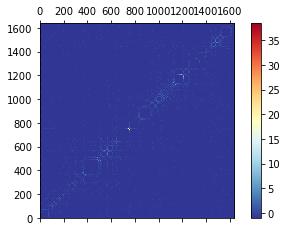

In [10]:
printMatrix(labels_score['chr22'], '', 1, 1, title='')

40.098864037
(300, 300)
Limit: 40.098864037


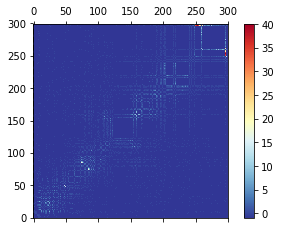

In [11]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(subset, '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


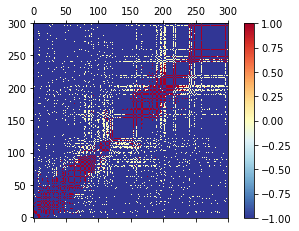

In [12]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize(subset), '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


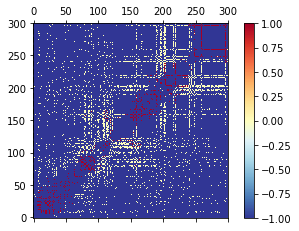

In [13]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize_w_unlabeled(subset, 1), '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


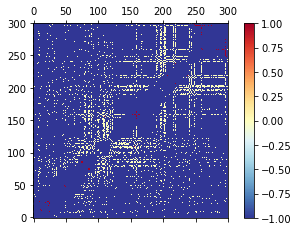

In [14]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize_w_unlabeled(subset, 5), '', 1, i, title='')

In [19]:
VectorATAC=get_features(pe_hindIII_file, atac, 'atac')

VectorCTCF=get_features(pe_hindIII_file, ctcf, 'ctcf')
VectorPOL3=get_features(pe_hindIII_file, pol3, 'pol3')
VectorTP63=get_features(pe_hindIII_file, TP63, 'TP63')
VectorLSD1=get_features(pe_hindIII_file, LSD1, 'LSD1')

VectorH3K27ac=get_features(pe_hindIII_file, H3K27ac, 'H3K27ac')
VectorH3K27me3=get_features(pe_hindIII_file, H3K27me3, 'H3K27me3')
VectorH3K4me1=get_features(pe_hindIII_file, H3K4me1, 'H3K4me1')
VectorH3K4me3=get_features(pe_hindIII_file, H3K4me3, 'H3K4me3')
VectorH3K9ac=get_features(pe_hindIII_file, H3K9ac, 'H3K9ac')

Average value with zeros:  17.7877534253
Average q-value w/o zeros:  29.806290671
Average value with zeros:  17.4185436398
Average q-value w/o zeros:  60.8430758098
Average value with zeros:  8.57758143989
Average q-value w/o zeros:  24.0185105009
Average value with zeros:  3.48607380351
Average q-value w/o zeros:  20.7594124695
Average value with zeros:  0.822780736851
Average q-value w/o zeros:  8.52913942804
Average value with zeros:  15.4516484053
Average q-value w/o zeros:  34.7538376962
Average value with zeros:  0.957330740411
Average q-value w/o zeros:  13.1510092054
Average value with zeros:  13.1783470926
Average q-value w/o zeros:  17.237235046
Average value with zeros:  37.0370038863
Average q-value w/o zeros:  113.711697451
Average value with zeros:  6.08860006674
Average q-value w/o zeros:  21.4206634158


In [21]:
VectorATAC['chr16'].shape

(2846,)

In [22]:
distance_for_node = build_distance_for_node(pe_hindIII_file)

In [23]:
distance_for_node['chr1'].shape

(11237, 1)

In [24]:
FeatureVector_wo_dist = {}
FeatureVector = {}
for chr in VectorATAC:
    if chr != 'chrY':
        FeatureVector_wo_dist[chr] = demean(np.vstack((VectorATAC[chr], VectorCTCF[chr], VectorPOL3[chr], VectorTP63[chr], VectorLSD1[chr], VectorH3K27ac[chr], VectorH3K27me3[chr], VectorH3K4me1[chr], VectorH3K4me3[chr], VectorH3K9ac[chr])).T)
        FeatureVector[chr] = np.concatenate((FeatureVector_wo_dist[chr], distance_for_node[chr]), axis=1)
#FeatureVectorDistance = demean(np.vstack((VectorATAC, VectorCTCF, VectorPOL3, VectorTP63, VectorLSD1, VectorH3K27ac, VectorH3K27me3, VectorH3K4me1, VectorH3K4me3, VectorH3K9ac, distance_for_node)).T)

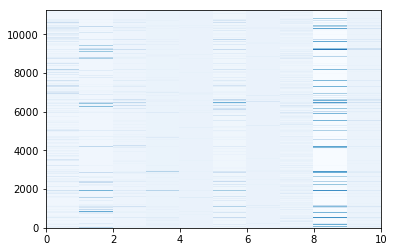

In [26]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(FeatureVector['chr1'][:,:10], cmap=plt.cm.Blues)

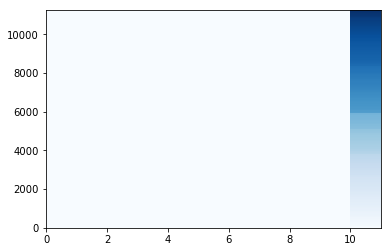

In [27]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(FeatureVector['chr1'], cmap=plt.cm.Blues)
#heatmap = ax.pcolor(DistanceFeatureVectorK, cmap=plt.cm.Blues)

In [ ]:
data, labels, indx  = get_data_labels(FeatureVector, labels_score)

In [ ]:
data_all_chrs, labels_all_chrs, indx_all_chr = concatenate_chrs(data, labels, indx)

In [ ]:
data_all_chrs_gt10kb_lt2Mb, labels_all_chrs_gt10kb_lt2Mb, indx_all_chrs_gt10kb_lt2Mb = impose_dist_constrains(data_all_chrs, labels_all_chrs, indx_all_chr, 10000, 2000000)

In [ ]:
data_all_chrs_gt10kb_lt2Mb.shape

In [ ]:
all_at_0 = binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 0)
all_at_5 = binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 5)
all_at_10 = binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 10)

In [ ]:
# data_all_wo_unlbd_at_0, labels_all_wo_unlbd_at_0 = remove_unlabeled(data_all_chrs_gt10kb_lt2Mb, binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 0))
# data_all_wo_unlbd_at_3, labels_all_wo_unlbd_at_3 = remove_unlabeled(data_all_chrs_gt10kb_lt2Mb, binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 3))
# data_all_wo_unlbd_at_5, labels_all_wo_unlbd_at_5 = remove_unlabeled(data_all_chrs_gt10kb_lt2Mb, binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 5))

In [ ]:
# data_all_wo_unlbd_at_0, labels_all_wo_unlbd_at_0, indx_all_wo_unlbd_at_0 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 0), indx_all_chr)
# data_all_wo_unlbd_at_3, labels_all_wo_unlbd_at_3, indx_all_wo_unlbd_at_3 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 3), indx_all_chr)
# data_all_wo_unlbd_at_5, labels_all_wo_unlbd_at_5, indx_all_wo_unlbd_at_5 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 5), indx_all_chr)
# data_all_wo_unlbd_at_7, labels_all_wo_unlbd_at_7, indx_all_wo_unlbd_at_7 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 7), indx_all_chr)
data_all_wo_unlbd_at_10, labels_all_wo_unlbd_at_10, indx_all_wo_unlbd_at_10 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 10), indx_all_chr)

In [ ]:
#train_set_thres_0, vali_set_thres_0, test_set_thres_0, labels_train_thres_0, labels_vali_thres_0, labels_test_thres_0, indx_train_thres_0, indx_vali_thres_0, indx_test_thres_0 =train_vali_test(data_all_wo_unlbd_at_0, labels_all_wo_unlbd_at_0, indx_all_wo_unlbd_at_0, 0.5, 0.3)

In [ ]:
#train_set_thres_3, vali_set_thres_3, test_set_thres_3, labels_train_thres_3, labels_vali_thres_3, labels_test_thres_3, indx_train_thres_3, indx_vali_thres_3, indx_test_thres_3 =train_vali_test(data_all_wo_unlbd_at_3, labels_all_wo_unlbd_at_3, indx_all_wo_unlbd_at_3, 0.5, 0.3)

In [ ]:
#train_set_thres_5, vali_set_thres_5, test_set_thres_5, labels_train_thres_5, labels_vali_thres_5, labels_test_thres_5, indx_train_thres_5, indx_vali_thres_5, indx_test_thres_5 =train_vali_test(data_all_wo_unlbd_at_5, labels_all_wo_unlbd_at_5, indx_all_wo_unlbd_at_5, 0.5, 0.3)

In [ ]:
#train_set_thres_7, vali_set_thres_7, test_set_thres_7, labels_train_thres_7, labels_vali_thres_7, labels_test_thres_7, indx_train_thres_7, indx_vali_thres_7, indx_test_thres_7 =train_vali_test(data_all_wo_unlbd_at_7, labels_all_wo_unlbd_at_7, indx_all_wo_unlbd_at_7, 0.5, 0.3)

In [ ]:
train_set_thres_10, vali_set_thres_10, test_set_thres_10, labels_train_thres_10, labels_vali_thres_10, labels_test_thres_10, indx_train_thres_10, indx_vali_thres_10, indx_test_thres_10 =train_vali_test(data_all_wo_unlbd_at_10, labels_all_wo_unlbd_at_10, indx_all_wo_unlbd_at_10, 0.5, 0.3)

In [ ]:
# min_dist=10000
# max_dist=2000000
# dist_step=10000
# class_imbalance=1
# X_test_distance_matched_at_0, y_test_distance_matched_at_0, indx_test_distance_matched_at_0  = get_pairs_distance_matched(test_set_thres_0, labels_test_thres_0, indx_test_thres_0, min_dist, max_dist, dist_step, class_imbalance)
# X_train_distance_matched_at_0, y_train_distance_matched_at_0, indx_train_distance_matched_at_0 = get_pairs_distance_matched(train_set_thres_0, labels_train_thres_0, indx_train_thres_0, min_dist, max_dist, dist_step, class_imbalance)
# X_valid_distance_matched_at_0, y_valid_distance_matched_at_0, indx_valid_distance_matched_at_0  = get_pairs_distance_matched(vali_set_thres_0, labels_vali_thres_0, indx_vali_thres_0, min_dist, max_dist, dist_step, class_imbalance)

In [ ]:
# min_dist=10000
# max_dist=2000000
# dist_step=10000
# class_imbalance=1
# X_test_distance_matched_at_3, y_test_distance_matched_at_3, indx_test_distance_matched_at_3 = get_pairs_distance_matched(test_set_thres_3, labels_test_thres_3, indx_test_thres_3, min_dist, max_dist, dist_step, class_imbalance)
# X_train_distance_matched_at_3, y_train_distance_matched_at_3, indx_train_distance_matched_at_3 = get_pairs_distance_matched(train_set_thres_3, labels_train_thres_3, indx_train_thres_3, min_dist, max_dist, dist_step, class_imbalance)
# X_valid_distance_matched_at_3, y_valid_distance_matched_at_3, indx_valid_distance_matched_at_3 = get_pairs_distance_matched(vali_set_thres_3, labels_vali_thres_3, indx_vali_thres_3, min_dist, max_dist, dist_step, class_imbalance)

In [ ]:
# min_dist=10000
# max_dist=2000000
# dist_step=10000
# class_imbalance=1
# X_test_distance_matched_at_5, y_test_distance_matched_at_5, indx_test_distance_matched_at_5 = get_pairs_distance_matched(test_set_thres_5, labels_test_thres_5, indx_test_thres_5, min_dist, max_dist, dist_step, class_imbalance)
# X_train_distance_matched_at_5, y_train_distance_matched_at_5, indx_train_distance_matched_at_5 = get_pairs_distance_matched(train_set_thres_5, labels_train_thres_5, indx_train_thres_5, min_dist, max_dist, dist_step, class_imbalance)
# X_valid_distance_matched_at_5, y_valid_distance_matched_at_5, indx_valid_distance_matched_at_5 = get_pairs_distance_matched(vali_set_thres_5, labels_vali_thres_5, indx_vali_thres_5, min_dist, max_dist, dist_step, class_imbalance)

In [ ]:
# min_dist=10000
# max_dist=2000000
# dist_step=10000
# class_imbalance=1
# X_test_distance_matched_at_7, y_test_distance_matched_at_7, indx_test_distance_matched_at_7 = get_pairs_distance_matched(test_set_thres_7, labels_test_thres_7, indx_test_thres_7, min_dist, max_dist, dist_step, class_imbalance)
# X_train_distance_matched_at_7, y_train_distance_matched_at_7, indx_train_distance_matched_at_7 = get_pairs_distance_matched(train_set_thres_7, labels_train_thres_7, indx_train_thres_7, min_dist, max_dist, dist_step, class_imbalance)
# X_valid_distance_matched_at_7, y_valid_distance_matched_at_7, indx_valid_distance_matched_at_7 = get_pairs_distance_matched(vali_set_thres_7, labels_vali_thres_7, indx_vali_thres_7, min_dist, max_dist, dist_step, class_imbalance)

In [ ]:
min_dist=10000
max_dist=2000000
dist_step=10000
class_imbalance=1
X_test_distance_matched_at_10, y_test_distance_matched_at_10, indx_test_distance_matched_at_10 = get_pairs_distance_matched(test_set_thres_10, labels_test_thres_10, indx_test_thres_10, min_dist, max_dist, dist_step, class_imbalance)
X_train_distance_matched_at_10, y_train_distance_matched_at_10, indx_train_distance_matched_at_10 = get_pairs_distance_matched(train_set_thres_10, labels_train_thres_10, indx_train_thres_10, min_dist, max_dist, dist_step, class_imbalance)
X_valid_distance_matched_at_10, y_valid_distance_matched_at_10, indx_valid_distance_matched_at_10 = get_pairs_distance_matched(vali_set_thres_10, labels_vali_thres_10, indx_vali_thres_10, min_dist, max_dist, dist_step, class_imbalance)

In [ ]:
# print "in all chrs:"
# y_at_0=np.concatenate((y_train_distance_matched_at_0, y_valid_distance_matched_at_0, y_test_distance_matched_at_0), axis=0)
# print "pos at thres=0: ", np.where(y_at_0 > 0)[0].shape[0]
# print "neg at thres=0: ", np.where(y_at_0 == 0)[0].shape[0]
# print "total: ", y_at_0.shape[0]

In [ ]:
# print "in all chrs:"
# y_at_3=np.concatenate((y_train_distance_matched_at_3, y_valid_distance_matched_at_3, y_test_distance_matched_at_3), axis=0)
# print "pos at thres=0: ", np.where(y_at_3 > 0)[0].shape[0]
# print "neg at thres=0: ", np.where(y_at_3 == 0)[0].shape[0]
# print "total: ", y_at_3.shape[0]

In [ ]:
# print "in all chrs:"
# y_at_5=np.concatenate((y_train_distance_matched_at_5, y_valid_distance_matched_at_5, y_test_distance_matched_at_5), axis=0)
# print "pos at thres=0: ", np.where(y_at_5 > 0)[0].shape[0]
# print "neg at thres=0: ", np.where(y_at_5 == 0)[0].shape[0]
# print "total: ", y_at_5.shape[0]

In [ ]:
# print "in all chrs:"
# y_at_7=np.concatenate((y_train_distance_matched_at_7, y_valid_distance_matched_at_10, y_test_distance_matched_at_7), axis=0)
# print "pos at thres=10: ", np.where(y_at_7 > 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_7 > 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_7 > 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_7 > 0)[0].shape[0] 
# print "neg at thres=10: ", np.where(y_at_7 == 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_7 == 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_7 == 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_7 == 0)[0].shape[0]
# print "total: ", y_at_7.shape[0]

In [ ]:
print "in all chrs:"
y_at_10=np.concatenate((y_train_distance_matched_at_10, y_valid_distance_matched_at_10, y_test_distance_matched_at_10), axis=0)
print "pos at thres=10: ", np.where(y_at_10 > 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_10 > 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_10 > 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_10 > 0)[0].shape[0] 
print "neg at thres=10: ", np.where(y_at_10 == 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_10 == 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_10 == 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_10 == 0)[0].shape[0]
print "total: ", y_at_10.shape[0]

In [ ]:
#count_nodes_and_contacts(indx_train_distance_matched_at_0, indx_valid_distance_matched_at_0, indx_test_distance_matched_at_0)

In [ ]:
#count_nodes_and_contacts(indx_train_distance_matched_at_3, indx_valid_distance_matched_at_3, indx_test_distance_matched_at_3)

In [ ]:
#count_nodes_and_contacts(indx_train_distance_matched_at_5, indx_valid_distance_matched_at_5, indx_test_distance_matched_at_5)

In [ ]:
#count_nodes_and_contacts(indx_train_distance_matched_at_7, indx_valid_distance_matched_at_7, indx_test_distance_matched_at_7)

In [ ]:
count_nodes_and_contacts(indx_train_distance_matched_at_10, indx_valid_distance_matched_at_10, indx_test_distance_matched_at_10)

In [ ]:
# np.save(DATAJDIR+'X_train_thres_10_maxij.npy', X_train_distance_matched_at_10) 
# np.save(DATAJDIR+'X_valid_thres_10_maxij.npy', X_valid_distance_matched_at_10) 
# np.save(DATAJDIR+'X_test_thres_10_maxij.npy', X_test_distance_matched_at_10) 
# np.save(DATAJDIR+'y_train_thres_10_maxij.npy', y_train_distance_matched_at_10)
# np.save(DATAJDIR+'y_valid_thres_10_maxij.npy', y_valid_distance_matched_at_10)
# np.save(DATAJDIR+'y_test_thres_10_maxij.npy', y_test_distance_matched_at_10)

In [ ]:
# np.save(DATAJDIR+'X_train_thres_0.npy', X_train_distance_matched_at_0) 
# np.save(DATAJDIR+'X_valid_thres_0.npy', X_valid_distance_matched_at_0) 
# np.save(DATAJDIR+'X_test_thres_0.npy', X_test_distance_matched_at_0) 
# np.save(DATAJDIR+'y_train_thres_0.npy', y_train_distance_matched_at_0)
# np.save(DATAJDIR+'y_valid_thres_0.npy', y_valid_distance_matched_at_0)
# np.save(DATAJDIR+'y_test_thres_0.npy', y_test_distance_matched_at_0)
# np.save(DATAJDIR+'indx_train_thres_0.npy', indx_train_distance_matched_at_0)
# np.save(DATAJDIR+'indx_valid_thres_0.npy', indx_valid_distance_matched_at_0)
# np.save(DATAJDIR+'indx_test_thres_0.npy', indx_test_distance_matched_at_0)

# np.save(DATAJDIR+'X_train_thres_3.npy', X_train_distance_matched_at_3) 
# np.save(DATAJDIR+'X_valid_thres_3.npy', X_valid_distance_matched_at_3) 
# np.save(DATAJDIR+'X_test_thres_3.npy', X_test_distance_matched_at_3) 
# np.save(DATAJDIR+'y_train_thres_3.npy', y_train_distance_matched_at_3)
# np.save(DATAJDIR+'y_valid_thres_3.npy', y_valid_distance_matched_at_3)
# np.save(DATAJDIR+'y_test_thres_3.npy', y_test_distance_matched_at_3)
# np.save(DATAJDIR+'indx_train_thres_3.npy', indx_train_distance_matched_at_3)
# np.save(DATAJDIR+'indx_valid_thres_3.npy', indx_valid_distance_matched_at_3)
# np.save(DATAJDIR+'indx_test_thres_3.npy', indx_test_distance_matched_at_3)

# np.save(DATAJDIR+'X_train_thres_5.npy', X_train_distance_matched_at_5) 
# np.save(DATAJDIR+'X_valid_thres_5.npy', X_valid_distance_matched_at_5) 
# np.save(DATAJDIR+'X_test_thres_5.npy', X_test_distance_matched_at_5) 
# np.save(DATAJDIR+'y_train_thres_5.npy', y_train_distance_matched_at_5)
# np.save(DATAJDIR+'y_valid_thres_5.npy', y_valid_distance_matched_at_5)
# np.save(DATAJDIR+'y_test_thres_5.npy', y_test_distance_matched_at_5)
# np.save(DATAJDIR+'indx_train_thres_5.npy', indx_train_distance_matched_at_5)
# np.save(DATAJDIR+'indx_valid_thres_5.npy', indx_valid_distance_matched_at_5)
# np.save(DATAJDIR+'indx_test_thres_5.npy', indx_test_distance_matched_at_5)

# np.save(DATAJDIR+'X_train_thres_7.npy', X_train_distance_matched_at_7) 
# np.save(DATAJDIR+'X_valid_thres_7.npy', X_valid_distance_matched_at_7) 
# np.save(DATAJDIR+'X_test_thres_7.npy', X_test_distance_matched_at_7) 
# np.save(DATAJDIR+'y_train_thres_7.npy', y_train_distance_matched_at_7)
# np.save(DATAJDIR+'y_valid_thres_7.npy', y_valid_distance_matched_at_7)
# np.save(DATAJDIR+'y_test_thres_7.npy', y_test_distance_matched_at_7)
# np.save(DATAJDIR+'indx_train_thres_7.npy', indx_train_distance_matched_at_7)
# np.save(DATAJDIR+'indx_valid_thres_7.npy', indx_valid_distance_matched_at_7)
# np.save(DATAJDIR+'indx_test_thres_7.npy', indx_test_distance_matched_at_7)


# np.save(DATAJDIR+'X_train_thres_10.npy', X_train_distance_matched_at_10) 
# np.save(DATAJDIR+'X_valid_thres_10.npy', X_valid_distance_matched_at_10) 
# np.save(DATAJDIR+'X_test_thres_10.npy', X_test_distance_matched_at_10) 
# np.save(DATAJDIR+'y_train_thres_10.npy', y_train_distance_matched_at_10)
# np.save(DATAJDIR+'y_valid_thres_10.npy', y_valid_distance_matched_at_10)
# np.save(DATAJDIR+'y_test_thres_10.npy', y_test_distance_matched_at_10)
# np.save(DATAJDIR+'indx_train_thres_10.npy', indx_train_distance_matched_at_10)
# np.save(DATAJDIR+'indx_valid_thres_10.npy', indx_valid_distance_matched_at_10)
# np.save(DATAJDIR+'indx_test_thres_10.npy', indx_test_distance_matched_at_10)
# #d = np.load('labels_test_all.npy')